In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadkhubaibahmad","key":"0a2a1397f34caf3396de4ef3a9accb92"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d mostafaabla/garbage-classification
!unzip garbage-classification.zip -d garbage_dataset

Streaming output truncated to the last 5000 lines.
  inflating: garbage_dataset/garbage_classification/paper/paper381.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper382.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper383.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper384.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper385.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper386.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper387.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper388.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper389.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper39.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper390.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper391.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper392.jpg  
 

In [5]:
import os
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In [6]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness= 0.2, contrast = 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [7]:
!ls garbage_dataset/garbage_classification

battery     brown-glass  clothes      metal  plastic  trash
biological  cardboard	 green-glass  paper  shoes    white-glass


In [8]:
import os
import shutil
from sklearn.model_selection import train_test_split

original_dir = 'garbage_dataset/garbage_classification'

base_dir = 'garbage_dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

for category in os.listdir(original_dir):
  category_path = os.path.join(original_dir, category)
  if os.path.isdir(category_path):
    imgs = os.listdir(category_path)
    train_imgs, val_imgs = train_test_split(imgs, test_size=0.2, random_state=42)

    # Make Subdir
    os.makedirs(os.path.join(train_dir, category), exist_ok = True)
    os.makedirs(os.path.join(val_dir, category), exist_ok = True)

    for img in train_imgs:
      shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category, img))
    for img in val_imgs:
      shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category, img))

In [9]:
!ls garbage_dataset_split/val

battery     brown-glass  clothes      metal  plastic  trash
biological  cardboard	 green-glass  paper  shoes    white-glass


In [10]:
train_dir = "garbage_dataset_split/train"
val_dir = "garbage_dataset_split/val"

train_data = datasets.ImageFolder(train_dir, transform = train_transforms)
val_data = datasets.ImageFolder(val_dir, transform = val_transforms)

train_loader = DataLoader(train_data, batch_size = 32, shuffle=True)
val_loader = DataLoader(val_data, batch_size = 32)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

# Replace final layer (classifier)
num_classes = len(train_data.classes)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, num_classes)
)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.4MB/s]


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

In [ ]:
import matplotlib.pyplot as plt
def train_model(model , train_loader, val_loader, criterion, optimizer, epochs = 10):
  train_loss_list = []
  val_acc_list = []
  train_acc_list = []
  for epoch in range(epochs):
    model.train()
    total_loss = correct = 0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      _, preds = torch.max(outputs, 1)
      correct += (preds == labels).sum().item()

    train_acc = correct / len(train_loader.dataset)
    train_acc_list.append(train_acc)
    train_loss_list.append(total_loss)

    # Validation

    model.eval()
    val_correct = 0
    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        val_correct += (preds == labels).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}: Loss={total_loss:.4f} | Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f}")


    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label="Train Acc")
    plt.plot(val_acc_list, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

  return model  # return model for saving

Epoch 1: Loss=247.1189 | Train Acc=0.7989 | Val Acc=0.8938


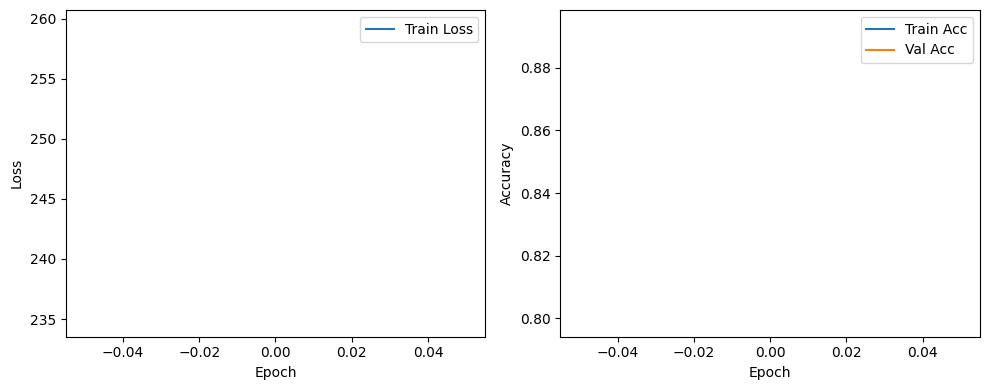

Epoch 2: Loss=239.8012 | Train Acc=0.8032 | Val Acc=0.9008


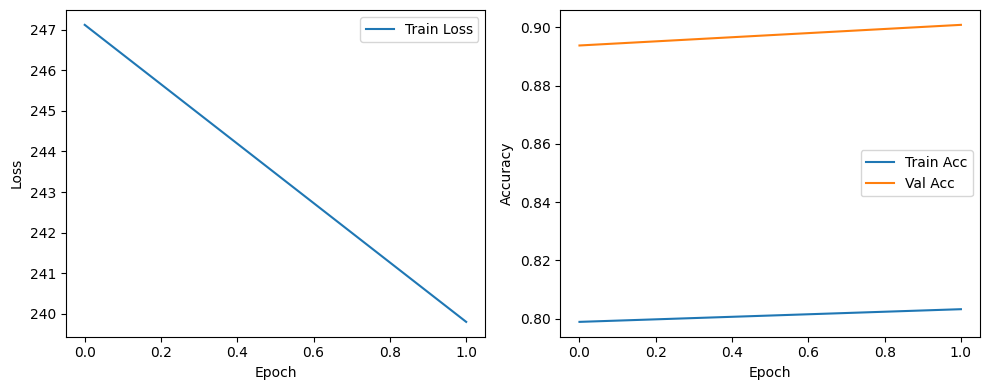

Epoch 3: Loss=242.5685 | Train Acc=0.7976 | Val Acc=0.8928


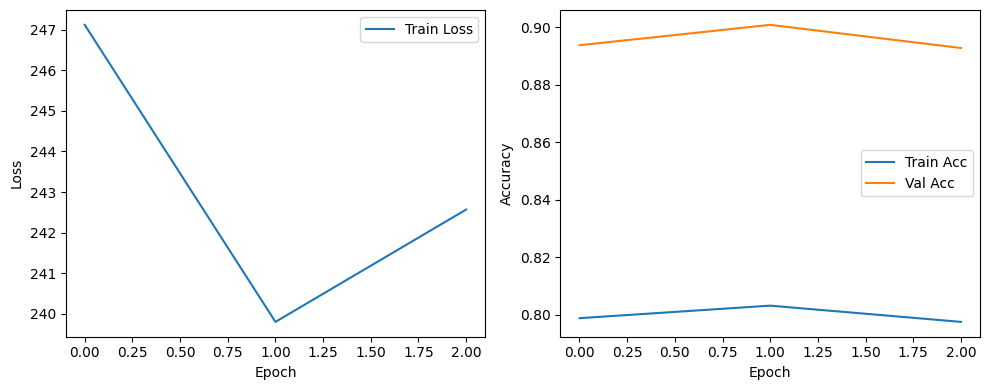

Epoch 4: Loss=241.5309 | Train Acc=0.7994 | Val Acc=0.9127


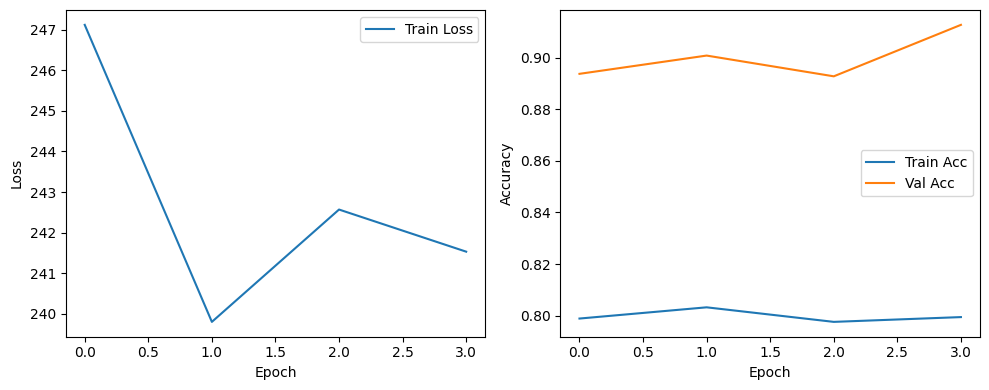

Epoch 5: Loss=237.3896 | Train Acc=0.8022 | Val Acc=0.9121


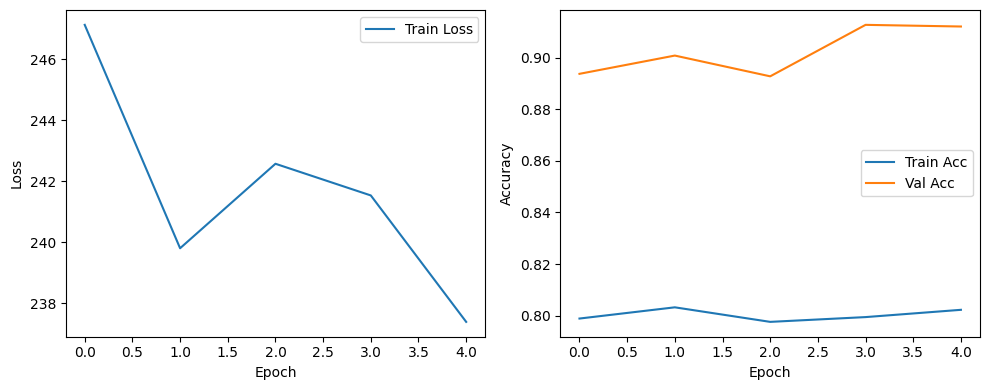

Epoch 6: Loss=236.4178 | Train Acc=0.8064 | Val Acc=0.9173


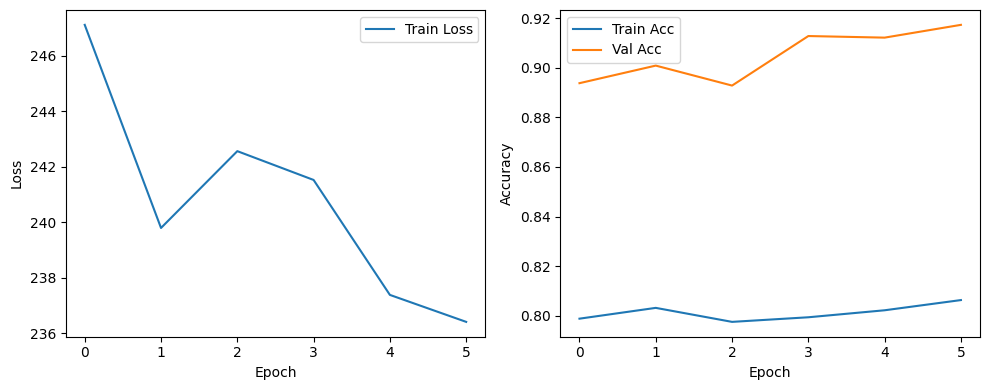

Epoch 7: Loss=241.5340 | Train Acc=0.8029 | Val Acc=0.9034


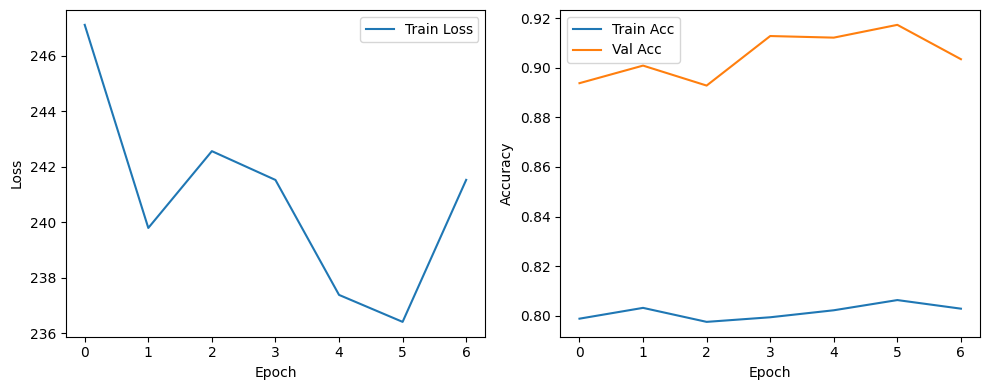

Epoch 8: Loss=232.9757 | Train Acc=0.8081 | Val Acc=0.9108


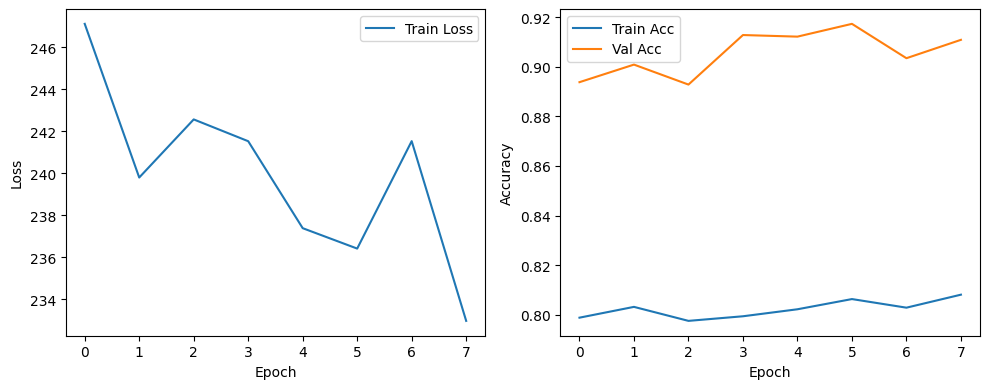

Epoch 9: Loss=240.1374 | Train Acc=0.8016 | Val Acc=0.9115


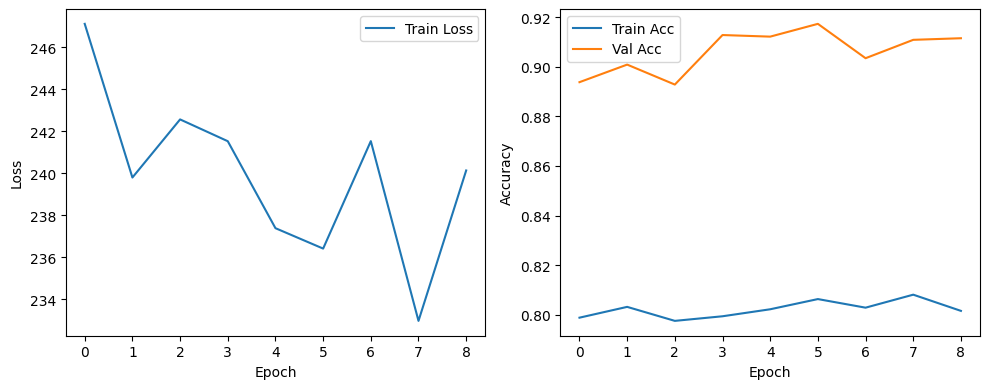

Epoch 10: Loss=237.8032 | Train Acc=0.8038 | Val Acc=0.9150


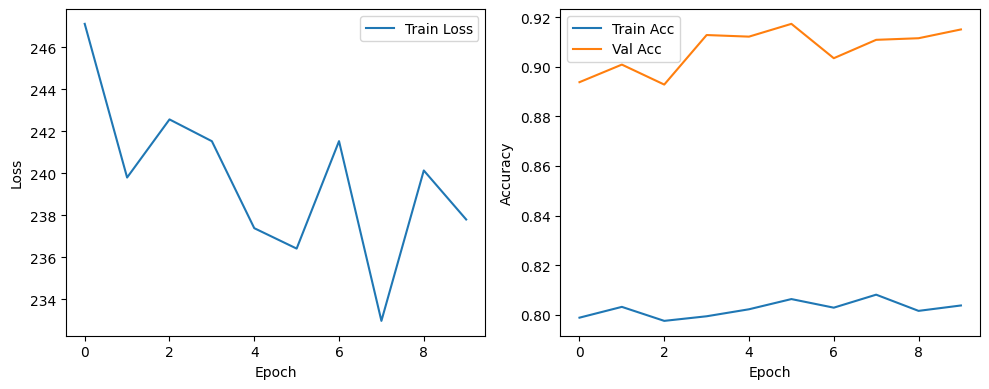

In [18]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs = 10)

#### Detailed evaluation report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_detailed(model, dataloader, class_names):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [ ]:
class_names = train_data.classes  # e.g. ['cardboard', 'glass', 'metal', ...]
evaluate_detailed(model, val_loader, class_names)


In [25]:
torch.save(model.state_dict(), 'garbage_classifier.pth')
print("Model saved Successfully")

Model saved Successfully


In [ ]:
# load model

In [30]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
  param.requires_grad=False

model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, num_classes)
)

model.load_state_dict(torch.load('garbage_classifier.pth'))
model = model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
def evaluate_model(model, dataloader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, preds = torch.max(outputs, 1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

  acc = correct/ total
  print(f"Validation Accuracy = {acc:.4f}")

In [32]:
evaluate_model(model, val_loader)

Validation Accuracy = 0.9150


In [ ]:
from PIL import Image

def predict(image_path, model):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = val_transforms(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
    return train_data.classes[pred.item()]

print(predict("garbage_dataset_split/val/metal/metal107.jpg", model))  # → "metal"

metal


In [36]:
!ls garbage_dataset_split/val/metal/metal107.jpg

metal107.jpg  metal225.jpg  metal372.jpg  metal497.jpg	metal670.jpg
metal110.jpg  metal232.jpg  metal374.jpg  metal508.jpg	metal673.jpg
metal111.jpg  metal243.jpg  metal391.jpg  metal518.jpg	metal674.jpg
metal115.jpg  metal245.jpg  metal394.jpg  metal520.jpg	metal679.jpg
metal119.jpg  metal249.jpg  metal397.jpg  metal530.jpg	metal691.jpg
metal11.jpg   metal252.jpg  metal3.jpg	  metal543.jpg	metal692.jpg
metal121.jpg  metal256.jpg  metal410.jpg  metal547.jpg	metal699.jpg
metal122.jpg  metal262.jpg  metal412.jpg  metal550.jpg	metal706.jpg
metal124.jpg  metal269.jpg  metal414.jpg  metal551.jpg	metal707.jpg
metal125.jpg  metal278.jpg  metal418.jpg  metal568.jpg	metal709.jpg
metal127.jpg  metal286.jpg  metal41.jpg   metal576.jpg	metal710.jpg
metal135.jpg  metal288.jpg  metal422.jpg  metal57.jpg	metal713.jpg
metal136.jpg  metal289.jpg  metal423.jpg  metal593.jpg	metal716.jpg
metal142.jpg  metal290.jpg  metal424.jpg  metal601.jpg	metal725.jpg
metal14.jpg   metal304.jpg  metal435.jpg  metal606